# Evaluating Foundation Models Trained with Earth Observation Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/developmentseed/igarss25tutorial/blob/main/tut2_EOFM_Evaluation.ipynb)

#### Using and evaluating EOFM

In the next portion, we will work through interactive demonstrations of how to use and evaluate EOFM for real domain-specific downstream tasks. Specifically, we will leverage two different EOFMs to generate embeddings for imagery before and after a natural hazard, and determine if these embeddings capture a descriptive pattern. We will also use these EOFMs in a fine tuning capacity to detect the natural hazard. After fine tuning, we'll calculate the performance scores. At the end, you will have worked through two different methods of leveraging EOFM using two different EOFM base models.

The two models we will work with include:
- Prithvi
- Clay

To begin evaluating the EOFMs, we will start with the Privthi model.

The [Prithvi HLS foundation model](https://github.com/NASA-IMPACT/Prithvi-EO-2.0) is an EOFM developed collaboratively by IBM and NASA. It leverages a **Vision Transformer (ViT)** architecture and is pre-trained on the [Harmonized Landsat-Sentinel-2 (HLS)](https://hls.gsfc.nasa.gov/) dataset. The model incorporates a **Masked Autoencoder (MAE)** self-supervised learning approach. Its design is optimized for spatiotemporal analysis, using 3D patch embeddings to encode spatial and temporal features from input data formatted as a sequence of geospatial "videos" (`B, C, T, H, W` — bands, channels, time, height, width). 

The architecture leverages temporal embeddings to model time-series dynamics and spatial embeddings to capture geospatial structure. Spectral inputs to Prithvi include six key spectral bands—Blue, Green, Red, Narrow NIR, SWIR1, and SWIR2—provided as geotiff files in reflectance units.

<img src="https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M/resolve/main/GFM.png" height="300" />

Image source: https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M

It has been fine-tuned for applications such as flood mapping, burn scar detection, and land cover classification. The pre-trained weights and fine-tuning workflows are openly available on platforms like Hugging Face, promoting accessibility and further development by the research community.

## Run Prithvi
This exercise involves carrying out a complete analysis from beginning to end. The steps include:
1. Selecting a location and time range of interest.
2. Downloading [Harmonized Landsat and Sentinel-2 (HLS)](https://hls.gsfc.nasa.gov/) imagery for the specified parameters (make sure you have an [Earth Data login](https://urs.earthdata.nasa.gov/) and [.netrc file](https://urs.earthdata.nasa.gov/documentation/for_users/data_access/create_net_rc_file) for this).
3. Loading the model checkpoint.
4. Formatting the data to match the model's requirements.
5. Running the model on the prepared imagery.
6. Performing PCA to analyze the model's output (embeddings).
7. Fine-tuning a classifier on top of the model's embeddings.

In [1]:
!pip install earthaccess>=0.14.0 pystac-client>=0.8.6 rioxarray>=0.19.0 stackstac>=0.5.1 terratorch>=1.0.2

In [2]:
import earthaccess

Calling [`earthaccess.login`](https://earthaccess.readthedocs.io/en/latest/user_guide/authenticate/#login-using-a-netrc) with `persist=True` will create a `.netrc` file for you.

In [3]:
earthaccess.login(persist=True)

In [4]:
import os
import urllib

import geopandas as gpd
import math
import numpy as np
import pandas as pd
import pystac_client
import rioxarray
import stackstac
import torch
import yaml

from box import Box
from einops import rearrange, reduce
from huggingface_hub import hf_hub_download
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point, mapping
from sklearn import decomposition, svm
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import MultinomialNB
from torchvision.transforms import v2
from terratorch import BACKBONE_REGISTRY

In [5]:
os.environ["GDAL_HTTP_COOKIEFILE"] = os.path.expanduser("~/.urs_cookies")
os.environ["GDAL_HTTP_COOKIEJAR"] = os.path.expanduser("~/.urs_cookies")
os.environ["GDAL_HTTP_NETRC"] = "YES"


### Define Location and Date of Interest
For this example, we analyze a region in Pakistan that experienced a monsoon flood. We will generate embeddings for the area with the model and analyze any relationships within those.

In [6]:
# Point over Padidan, Pakistan
lat, lon = 26.776567, 68.287374

# Dates surrounding a major monsoon flood (August 20, 2022)
start = "2022-06-01"
end = "2022-10-30"

### Retrieve Data from the STAC Catalog
Using the specified location and dates, let's obtain [Harmonized Landsat and Sentinel-2 (HLS)](https://hls.gsfc.nasa.gov/) imagery with `stackstac`. We'll parameterize our search query so as to only retrieve the desired STAC items for analysis.

In [120]:
STAC_API = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
COLLECTION = "HLSS30.v2.0"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)

search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    intersects=mapping(Point(lon, lat)) ,
    max_items=100,
    query={"eo:cloud_cover": {"lt": 50}},
)

all_items =  search.item_collection()
all_items
item = all_items[0]
item

# Use S3 links for downloading imagery
for item in all_items:
    for key in item.assets.keys():
        if "alternate" in item.assets[key].extra_fields:
            url = urllib.parse.urlparse(
                item.assets[key].extra_fields["alternate"]["s3"]["href"]
            )
            item.assets[key].href = f"https://{url.netloc}.s3.amazonaws.com{url.path}"
            item.assets[key].href = item.assets[key].extra_fields["alternate"]["s3"][
                "href"
            ]

items = []
dates = []
for item in all_items:
    items.append(item)
    dates.append(item.datetime.date())


print(f"Found {len(items)} items")

Found 22 items


### Create a Bounding Box for the Area of Interest
We'll generate this bounding box in the projection of the dataset to ensure appropriately sized image chips.


In [125]:
# Extract coordinate system
epsg = 32642 # For Padidan, Pakistan.

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

# Get lat and lon in meters (UTM), where lat and lon are at the center of our intended image chip.
coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 30
# This creates a bounding box of 256 × 30m = 7680m × 7680m (7.68 km square), centered on the point.
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

### Retrieve the imagery data

In [126]:
# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use the
# RGB, NIR and SWIR bands.
# Clip the imagery to the defined bounds.
# Use nearest-neighbor resampling to avoid interpolation artifacts.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["B02", "B03", "B04", "B05", "B06", "B07"],
    resampling=Resampling.nearest,
)

print(f"Working with stack of size {stack.shape}")

stack = stack.compute()

stack

Working with stack of size (22, 6, 256, 256)


<xarray.DataArray 'stackstac-6660faf8ea61a5edf928f9680cc4d9ff' (time: 22,
                                                                band: 6,
                                                                y: 256, x: 256)> Size: 69MB
array([[[[ 719.,  732.,  849., ..., 1277., 1306., 1307.],
         [ 659.,  666.,  683., ..., 1146., 1144., 1151.],
         [ 672.,  644.,  643., ...,  829.,  782.,  878.],
         ...,
         [1140., 1342., 1264., ..., 1148., 1108., 1059.],
         [1146., 1337., 1168., ..., 1291., 1224.,  999.],
         [1066., 1227., 1138., ..., 1303.,  995.,  995.]],

        [[1211., 1211., 1322., ..., 1837., 1888., 1915.],
         [1170., 1151., 1170., ..., 1683., 1691., 1712.],
         [1179., 1157., 1150., ..., 1346., 1274., 1383.],
         ...,
         [1649., 1897., 1791., ..., 1730., 1683., 1623.],
         [1644., 1877., 1674., ..., 1896., 1811., 1564.],
         [1543., 1755., 1656., ..., 1914., 1553., 1547.]],

        [[1111., 1125., 1345., ..., 2354., 2421., 2488.],
         [1002.,  951., 1018., ..., 2077., 2107., 2146.],
         [1001.,  977., 1004., ..., 1555., 1503., 1644.],
         ...,
...
         [1325., 1469., 1345., ..., 1730., 1664., 1529.],
         [1314., 1439., 1304., ..., 1885., 1952., 1560.],
         [1251., 1310., 1240., ..., 1845., 2049., 1540.]],

        [[2124., 2118., 2149., ..., 2037., 2278., 2047.],
         [2213., 2201., 2323., ..., 1835., 2050., 1830.],
         [2387., 2415., 2442., ..., 1268., 1255., 1297.],
         ...,
         [2064., 2529., 2412., ..., 2103., 2032., 1853.],
         [2062., 2452., 2317., ..., 2038., 2190., 1895.],
         [2030., 2380., 2303., ..., 2083., 2266., 1924.]],

        [[2469., 2469., 2486., ..., 2435., 2728., 2444.],
         [2598., 2611., 2746., ..., 2153., 2380., 2188.],
         [2837., 2877., 2944., ..., 1449., 1409., 1407.],
         ...,
         [2353., 2934., 2772., ..., 2244., 2249., 2007.],
         [2361., 2840., 2688., ..., 2213., 2346., 2058.],
         [2321., 2861., 2713., ..., 2248., 2394., 2089.]]]],
      shape=(22, 6, 256, 256))
Coordinates:
  * time             (time) datetime64[ns] 176B 2022-06-02T06:11:57.759000 .....
    id               (time) <U34 3kB 'HLS.S30.T42RVQ.2022153T055641.v2.0' ......
  * band             (band) <U3 72B 'B02' 'B03' 'B04' 'B05' 'B06' 'B07'
  * x                (x) float64 2kB 4.253e+05 4.253e+05 ... 4.329e+05 4.33e+05
  * y                (y) float64 2kB 2.966e+06 2.966e+06 ... 2.958e+06 2.958e+06
    start_datetime   (time) <U24 2kB '2022-06-02T06:11:57.759Z' ... '2022-10-...
    eo:cloud_cover   (time) int64 176B 0 0 21 0 0 0 20 43 36 ... 0 0 0 0 0 1 0 0
    end_datetime     (time) <U24 2kB '2022-06-02T06:11:57.759Z' ... '2022-10-...
    storage:schemes  object 8B {'aws': {'type': 'aws-s3', 'platform': 'https:...
    epsg             int64 8B 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(425316.3841495511, 2958046.86...
    crs:         epsg:32642
    transform:   | 30.00, 0.00, 425316.38|\n| 0.00,-30.00, 2965726.86|\n| 0.0...
    resolution:  30

### Review the Downloaded Imagery
The imagery dataset contains eight pre-flood images (one of which is cloudy) and 14 post-flood images.

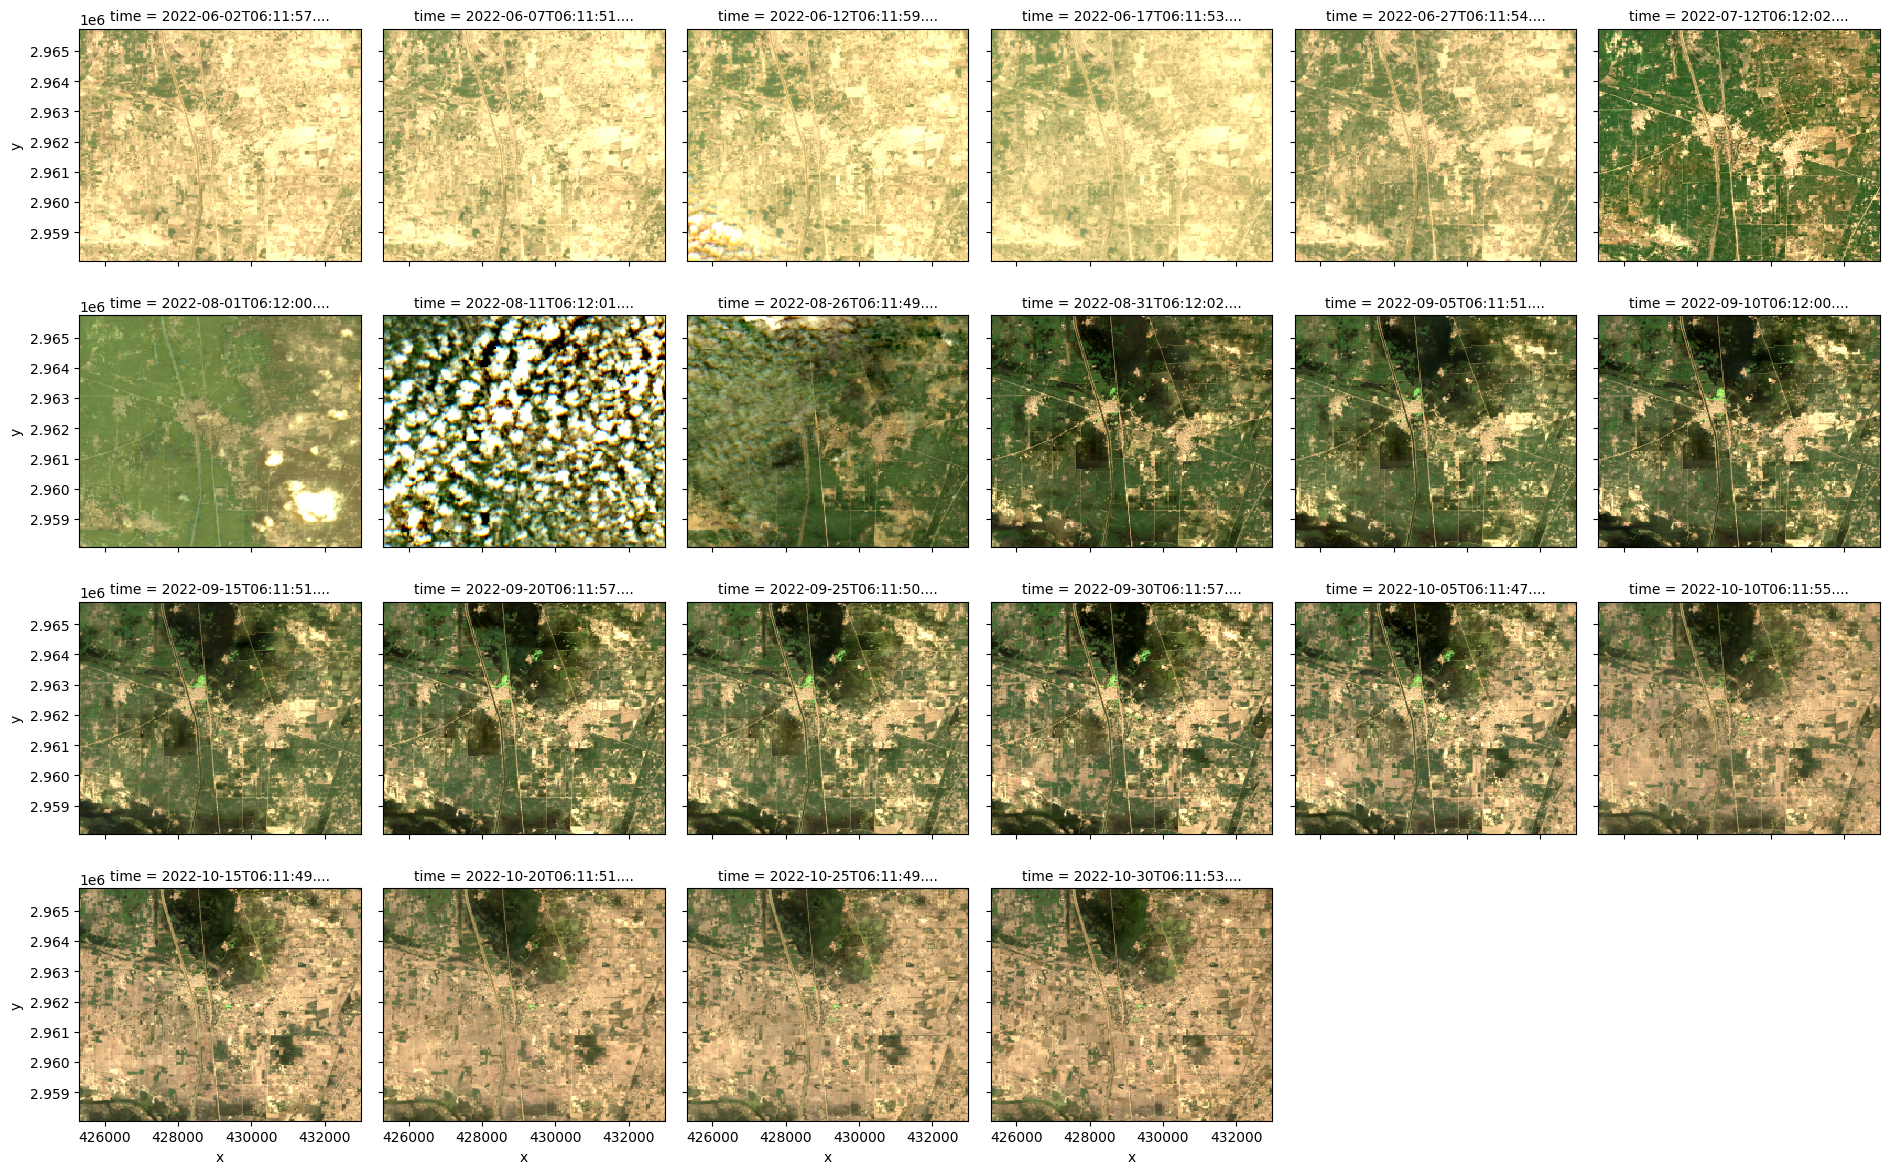

In [127]:
stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

In [128]:
stack.shape

(22, 6, 256, 256)

### Load the Model
Now that we have the imagery prepared, the next step is to load the model for analysis.

In [129]:
from terratorch import BACKBONE_REGISTRY

# Find and print available Prithvi models in the model registry
print([model_name for model_name in BACKBONE_REGISTRY if "terratorch_prithvi" in model_name])

# Check that the model we want to use is in the registry
"terratorch_prithvi_eo_v2_300" in BACKBONE_REGISTRY

# instantiate our desired model
# NOTE: the backbone registry prefix (e.g., `terratorch`) is optional
model = BACKBONE_REGISTRY.build("prithvi_eo_v2_300", pretrained=True)

['terratorch_prithvi_eo_tiny', 'terratorch_prithvi_eo_v1_100', 'terratorch_prithvi_eo_v2_300', 'terratorch_prithvi_eo_v2_600', 'terratorch_prithvi_eo_v2_300_tl', 'terratorch_prithvi_eo_v2_600_tl']


### Format Band Pixel Data for the Model
Now we will transform the imagery stack into the format required by the model.
Prithvi uses short time series of four images, "quadruplets," as input. Due to limited data, overlapping dates are used to create 19 quadruplets: the first spans dates 1 to 4, the second covers dates 2 to 5, and so forth.

In [130]:
input_size = [1,size,size]
patch_size = [1,16,16]

In [131]:
chips = []
for i in range(19):
    chips.append(stack.isel(time=slice(i, i + 4)).values)
chips[0].shape

(4, 6, 256, 256)

In [132]:
len(chips)

19

We get 19 chips to represent the 19 combinations of temporal sequences where the time series length is 4.

In [133]:
chip_time_indices = [[i, i+1, i+2, i+3] for i in range(19)]

In [134]:
len(chip_time_indices)

19

In [135]:
chip_time_indices

[[0, 1, 2, 3],
 [1, 2, 3, 4],
 [2, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 6, 7],
 [5, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8, 9, 10],
 [8, 9, 10, 11],
 [9, 10, 11, 12],
 [10, 11, 12, 13],
 [11, 12, 13, 14],
 [12, 13, 14, 15],
 [13, 14, 15, 16],
 [14, 15, 16, 17],
 [15, 16, 17, 18],
 [16, 17, 18, 19],
 [17, 18, 19, 20],
 [18, 19, 20, 21]]

### Execute the Model
Now we pass the prepared datacube to the model to generate one embedding vector for each image.

In [136]:
embeddings = []

# Iterate over each chip (sequence of 4 timesteps)
for ts in chips:
    # Rearrange tensor to match model input format: add batch dimension and put time in the middle
    ts = rearrange(ts, "t c h w -> 1 c t h w")
    ts = ts.astype(np.float32)
    # Only process chips with 4 time steps (quadruplets)
    if ts.shape[2] == 4:
        embedding = model.forward(torch.from_numpy(ts)) # Run model to get embeddings
        # Extract the class token (represents a summary or global representation of the entire input sequence (here, 4 timesteps of the chip))
        # `:` means all batches — here, size 1, `0` means the first token (the CLS token), `:` means all embedding dimensions
        # so the shape of cls_embedding before unraveling is (batch_size, embedding_dim), and if the batch size is 1, then after it is (embedding_dim,)
        cls_embedding = embedding[0][:, 0, :].detach().cpu().numpy().ravel()
        embeddings.append(cls_embedding)

embeddings = np.array(embeddings)

In [137]:
embeddings[0].shape

(1024,)

In [138]:
len(embeddings)

19

### Analyze the Embeddings
Now we will run a simple analysis to find any patterns in the model's understanding of the data. PCA is applied to reduce each embedding to a single value. 
Embeddings, whether class or patch level, from models like transformers are usually high-dimensional vectors (e.g., 768, 1024 dims). PCA reduces this to fewer dimensions (e.g., 1 or 2) for easier analysis or visualization. By projecting embeddings into 2D with PCA, you can visualize how samples relate to each other—whether they cluster by class, time, or some other property. This is because PCA extracts principal components that capture the largest variance in the embeddings, potentially removing noise or irrelevant features and focusing on the most important aspects. As such, lower-dimensional representations from PCA can be used as input features for clustering, classification, or anomaly detection algorithms with less computational cost and potentially better generalization.

The PCA-reduced embeddings, as you'll see, appear to be grouped into four categories within PCA space: pre-flood images, during flood images, cloudy images, and post-flood images.


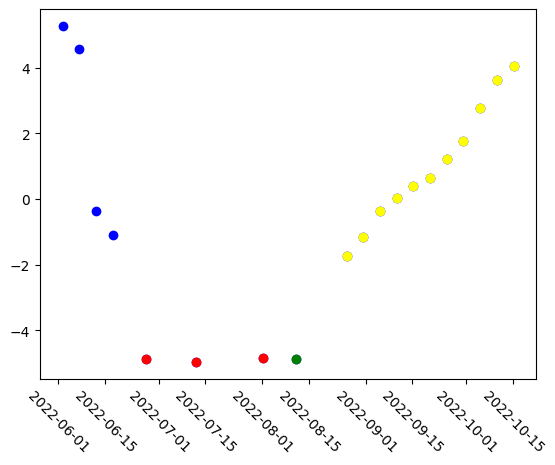

In [139]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time[:19], pca_result, color="blue")

# # Re-plot cloudy images in green
plt.scatter(stack.time[7], pca_result[7], color="green")

# Color all images occuring during the flood in red
plt.scatter(stack.time[4:7], pca_result[4:7], color="red")

# Color all images after flood in yellow
plt.scatter(stack.time[8:19], pca_result[8:19], color="yellow")

### Embeddings for Each Time Step
The model also generates embeddings for individual time steps. These embeddings are extracted for each input quadruplet and visualized using PCA, revealing similar clustering patterns.

The first version generates an embedding for each timesep in each quadruplet, which encounters some redundancy as a given timestep is inherently present in multiple quadruplets.

In [140]:
long_embeddings_quadruplets = []

# Iterate over each chip (sequence of 4 timesteps)
for ts in chips:
    # Rearrange tensor to match model input format: add batch dimension and put time in the middle
    ts = rearrange(ts, "t c h w -> 1 c t h w")
    ts = ts.astype(np.float32)
    # Only process chips with 4 time steps (quadruplets)
    if ts.shape[2] == 4:
        embedding = model.forward(torch.from_numpy(ts)) # Run model to get embeddings
        # Extract class token (embedding vector for the whole chip (4 timesteps combined))
        cls_embedding = embedding[0][:, 0, :].detach().cpu().numpy().ravel()
        # Reshape to (t, n, d): time, patch tokens, embedding dim
        embedding = rearrange(embedding[0][:, 1:, :], "1 (t n) d -> 1 t n d", t=4)[0]
        # Average patch tokens per timestep: shape becomes (t, d)
        # gives us one averaged patch embedding per timestep
        embedding = reduce(embedding, "t n d -> t d", "mean").detach().numpy()
        # Store the embedding quadruplet
        t0, t1, t2, t3 = embedding
        long_embeddings_quadruplets.extend([t0] + [t1] + [t2] + [t3])

In [141]:
len(long_embeddings_quadruplets)

76

This second version stores only one embedding for a given timestep (appends the embedding based on its time index if that time index has not already been added).

In [142]:
long_embeddings_dict = {}

# Iterate over each chip (sequence of 4 timesteps) and its index
for i, ts in enumerate(chips):
    time_ids = chip_time_indices[i]  # Global timestep indices for this chip, e.g., [0, 1, 2, 3]
    # Rearrange tensor to match model input format: add batch dimension and put time in the middle
    ts = rearrange(ts, "t c h w -> 1 c t h w").astype(np.float32)

    # Only process chips with 4 time steps (quadruplets)
    if ts.shape[2] == 4:
        with torch.no_grad():
            embedding = model.forward(torch.from_numpy(ts)) # Run model to get embeddings

        # Extract CLS token, reshape to (t, n, d): time, patch tokens, embedding dim
        embedding = rearrange(embedding[0][:, 1:, :], "1 (t n) d -> 1 t n d", t=4)[0]
        # Average patch tokens per timestep: shape becomes (t, d)
        # gives us one averaged patch embedding per timestep
        embedding = reduce(embedding, "t n d -> t d", "mean").detach().numpy()

        # Store each timestep's embedding using the original (global) time index
        for j, t_idx in enumerate(time_ids):
            if t_idx not in long_embeddings_dict:
                long_embeddings_dict[t_idx] = embedding[j]

# Reconstruct a list of embeddings ordered by all 22 possible timesteps (if available)
all_timesteps = list(range(22))
long_embeddings = [long_embeddings_dict[t] for t in all_timesteps if t in long_embeddings_dict]

In [143]:
len(long_embeddings)

22

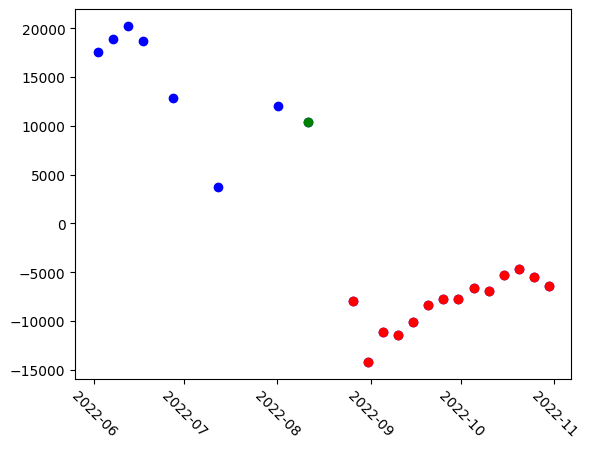

In [144]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(long_embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time, pca_result, color="blue")

# Re-plot cloudy images in green
plt.scatter(stack.time[7], pca_result[7], color="green")

# Color all images after flood in red
plt.scatter(stack.time[8:], pca_result[8:], color="red")

### Fine-Tune the Model
Now we will train a classifier head for detecting flood events on top of the embeddings. Our dataset is tiny (22 samples), so we will choose a suitable method: Support Vector Machine. An SVM is a supervised machine learning model that tries to find the best boundary (or boundaries) between different classes of data in a feature space. At this point, we’re treating the EOFM as a feature extractor (fixed), and only training a small classifier (the SVM) on top. Given that, SVM fits well — it learns fast and doesn't overfit as easily as deeper classifiers.

In [145]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Pre-flood
# 2 = Post-flood

labels = np.array([1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Split into fit and test manually, with an effort to have all 3 classes in both sets 
# (since there is only one cloudy sample, we use it for training only)
fit = [0, 2, 4, 6, 7, 8, 10, 12, 14, 16, 18, 20]
test = [1, 3, 5, 9, 11, 13, 15, 17, 19, 21]

# Train a support vector machine model
long_embeddings = np.array(long_embeddings)
clf = svm.SVC()
clf.fit(long_embeddings[fit], labels[fit])

# Predict classes on test set
prediction = clf.predict(long_embeddings[test])

# Match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")

Matched 9 out of 10 correctly


## Clay

The Clay Foundation model is another open source EOFM. It also utilizes a **Vision Transformer (ViT)** architecture with a **masked autoencoder** approach. The encoder of the model consists of several layers, each with multiple attention heads, allowing it to capture complex spatial and temporal relationships in the data. The self-attention mechanism enables it to understand both local and global features within satellite imagery. The decoder is structured similarly but with fewer layers and attention heads, and it is optimized for efficient reconstruction during the pre-training phase. The architecture uses an MLP (Multi-Layer Perceptron) layer for feature extraction. 

The model is trained on a large dataset that combines multi-modal geospatial data from Landsat 8 and 9, Sentinel-2 L2A, Sentinel-1 RTC, NAIP and LINZ. A sampling strategy carefully curated to cover a variety of land types was implemented, ensuring diverse geographical and seasonal representation. 

The architecture and data inputs make Clay highly flexible. 

For more details, you can visit the official [Clay Foundation website](https://madewithclay.org) or the [documentation website](https://clay-foundation.github.io/model/index.html).

Let's get the necessary code for Clay.

In [24]:
!mkdir clay

In [ ]:
cd clay

In [26]:
!git clone --depth=1 https://github.com/Clay-foundation/model

In [ ]:
cd model

In [147]:
ls

claymodel/          copy_data.sh        pyproject.toml      trainer.py
cluster/            docs/               README.md           utils/
CODE_OF_CONDUCT.md  environment.yml     ruff.toml
configs/            LICENSE             train_clay.sh


In [148]:
import sys
sys.path.append("./claymodel/")
from claymodel.module import ClayMAEModule

The tile size for Prithvi was 256. For Clay, it is 224, so we will need to re-create our stacked dataset using that value.

In [149]:
# Create bounds in projection
size = 224
gsd = 30
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use the
# RGB, NIR and SWIR bands.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["B02", "B03", "B04", "B05", "B06", "B07"],
    resampling=Resampling.nearest,
)

print(f"Working with stack of size {stack.shape}")

stack = stack.compute()

stack

Working with stack of size (22, 6, 224, 224)


<xarray.DataArray 'stackstac-4a398c78c1a9d2008d62b4c3a2a17078' (time: 22,
                                                                band: 6,
                                                                y: 224, x: 224)> Size: 53MB
array([[[[1163.,  656.,  663., ..., 1311., 1430., 1367.],
         [1181.,  699.,  649., ..., 1403., 1568., 1463.],
         [1170.,  749.,  695., ..., 1567., 1604., 1553.],
         ...,
         [1107., 1135., 1121., ...,  959.,  929.,  795.],
         [1150., 1186., 1116., ...,  848.,  843.,  769.],
         [1093., 1180., 1094., ...,  984.,  897.,  759.]],

        [[1675., 1124., 1144., ..., 1855., 1984., 1935.],
         [1706., 1174., 1131., ..., 1929., 2153., 2042.],
         [1684., 1171., 1121., ..., 2159., 2211., 2143.],
         ...,
         [1672., 1656., 1663., ..., 1460., 1413., 1314.],
         [1695., 1719., 1678., ..., 1410., 1388., 1178.],
         [1643., 1741., 1650., ..., 1541., 1429., 1151.]],

        [[1924., 1065., 1084., ..., 2266., 2411., 2362.],
         [2007., 1160., 1060., ..., 2347., 2610., 2467.],
         [2013., 1160., 1051., ..., 2616., 2732., 2614.],
         ...,
...
         [1211., 1258., 1301., ..., 1765., 1608., 1015.],
         [1364., 1412., 1407., ..., 1608., 1529.,  876.],
         [1388., 1396., 1436., ..., 1693., 1551.,  903.]],

        [[1626., 2044., 2033., ..., 1447., 1552., 1523.],
         [1674., 2328., 2301., ..., 1436., 1579., 1604.],
         [1713., 2387., 2293., ..., 1482., 1604., 1728.],
         ...,
         [1230., 1345., 1405., ..., 1905., 1968., 1722.],
         [1513., 1495., 1493., ..., 1851., 1866., 1723.],
         [1519., 1551., 1552., ..., 1875., 1882., 1707.]],

        [[1800., 2477., 2539., ..., 1584., 1654., 1670.],
         [1919., 2822., 2765., ..., 1573., 1690., 1747.],
         [1863., 2887., 2739., ..., 1603., 1735., 1876.],
         ...,
         [1353., 1467., 1513., ..., 2079., 2202., 2138.],
         [1623., 1605., 1598., ..., 1985., 2123., 2218.],
         [1625., 1662., 1664., ..., 2039., 2095., 2137.]]]],
      shape=(22, 6, 224, 224))
Coordinates:
  * time             (time) datetime64[ns] 176B 2022-06-02T06:11:57.759000 .....
    id               (time) <U34 3kB 'HLS.S30.T42RVQ.2022153T055641.v2.0' ......
  * band             (band) <U3 72B 'B02' 'B03' 'B04' 'B05' 'B06' 'B07'
  * x                (x) float64 2kB 4.258e+05 4.258e+05 ... 4.325e+05 4.325e+05
  * y                (y) float64 2kB 2.965e+06 2.965e+06 ... 2.959e+06 2.959e+06
    start_datetime   (time) <U24 2kB '2022-06-02T06:11:57.759Z' ... '2022-10-...
    eo:cloud_cover   (time) int64 176B 0 0 21 0 0 0 20 43 36 ... 0 0 0 0 0 1 0 0
    end_datetime     (time) <U24 2kB '2022-06-02T06:11:57.759Z' ... '2022-10-...
    storage:schemes  object 8B {'aws': {'type': 'aws-s3', 'platform': 'https:...
    epsg             int64 8B 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(425796.3841495511, 2958526.86...
    crs:         epsg:32642
    transform:   | 30.00, 0.00, 425796.38|\n| 0.00,-30.00, 2965246.86|\n| 0.0...
    resolution:  30


### Load the model

We now have the data to analyse, let's load the model. But first, we need to rename the bands to match what's expected in the config file.

In [150]:
stack.band.values

array(['B02', 'B03', 'B04', 'B05', 'B06', 'B07'], dtype='<U3')

In [151]:
if "band" in stack.coords:
    stack = stack.assign_coords(band=["red" if b == "B04" else b for b in stack.band.values])
    stack = stack.assign_coords(band=["green" if b == "B03" else b for b in stack.band.values])
    stack = stack.assign_coords(band=["blue" if b == "B02" else b for b in stack.band.values])
    stack = stack.assign_coords(band=["nir" if b == "B05" else b for b in stack.band.values])
    stack = stack.assign_coords(band=["swir16" if b == "B06" else b for b in stack.band.values])
    stack = stack.assign_coords(band=["swir22" if b == "B07" else b for b in stack.band.values])

In [152]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://huggingface.co/made-with-clay/Clay/resolve/main/v1.5/clay-v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt,
    model_size="large",
    metadata_path="./configs/metadata.yaml",
    mask_ratio=0.0,
    shuffle=False,
)
model.eval()

model = model.to(device)

### Prepare Band Metadata for Model Input  
This step is the most technical so far. It involves processing the imagery stack and converting its data into the format required by the model. This includes normalizing the latitude/longitude and the imagery's date values.  

The Clay model is designed to accept any combination of bands in any order, even from different platforms. However, the model requires metadata about each band, including its central wavelength and normalization parameters. This information allows the model to standardize the data and correctly interpret each band based on its wavelength.  

For Sentinel-2, we can extract these details from the model's metadata file. For other platforms, a custom approach may be needed to provide this information. For simplicity here, we utilize the Sentinel-2 parameters for our HLS imagery.

In [153]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

### Convert Band Pixel Data to Model Format 
This step involves transforming the imagery stack into the format required by the model. It includes normalizing the latitude/longitude and the imagery's date values.

In [154]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using a normalization function from the model code.
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

### Combine Metadata and Pixels
All required inputs, including metadata and transformed pixel values, are compiled into a single dictionary.

In [155]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.rio.resolution()[0], device=device),
    "waves": torch.tensor(waves, device=device),
}

### Execute the Model
The datacube is passed to the model, which generates one embedding vector per image.


In [156]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [157]:
len(embeddings)

22

### Analyze the Embeddings 
A straightforward way to analyze the embeddings is by reducing each to a single value using Principal Component Analysis (PCA). This involves fitting a PCA model to the embeddings and performing dimensionality reduction. The resulting PCA space reveals three distinct groups: earlier images, cloudy images, and post-flood images, each occupying a different range within the PCA space.

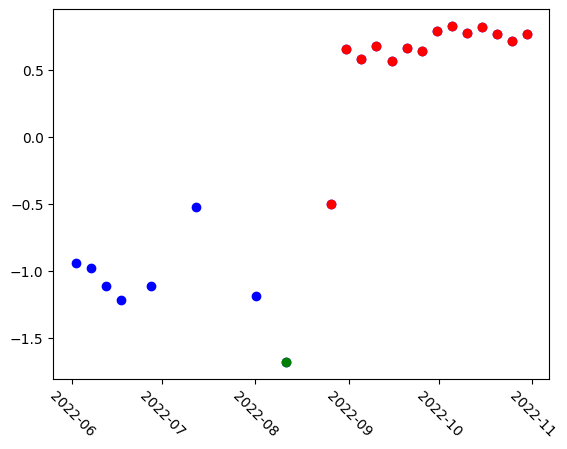

In [158]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time, pca_result, color="blue")

# Re-plot cloudy images in green
plt.scatter(stack.time[7], pca_result[7], color="green")

# Color all images after flood in red
plt.scatter(stack.time[8:], pca_result[8:], color="red")

### Fine-Tune the Model
Finally, a classifier is again trained on the embeddings to identify flood events.

In [159]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Pre-flood
# 2 = Post-flood
labels = np.array([1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Split into fit and test manually, with an effort to have all 3 classes in both sets 
# (since there is only one cloudy sample, we use it for training only)
fit = [0, 2, 4, 6, 7, 8, 10, 12, 14, 16, 18, 20]
test = [1, 3, 5, 9, 11, 13, 15, 17, 19, 21]

# Train a Support Vector Machine model
clf = svm.SVC()
clf.fit(embeddings[fit], labels[fit])

# Predict classes on test set
prediction = clf.predict(embeddings[test])

# Perfect match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")

Matched 9 out of 10 correctly


In [163]:
labels[test]

array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

In [164]:
prediction

array([1, 1, 2, 2, 2, 2, 2, 2, 2, 2])

### Change Detection Heatmap (Pre- vs. Post-Flood Distances)

We can generate a heatmap to visualize pairwise distances between embeddings from pre-flood and post-flood periods. Each cell's value represents the distance between a specific pre-flood and post-flood embedding.

We will also compute the average distance. A high average distance suggests that the model identifies significant differences between pre- and post-flood conditions. This could reflect meaningful changes in the landscape.

As for the heatmap, pattern consistency is key to look for. Uniformity in the heatmap (similar distances across all pairs) indicates a consistent model response to changes. Non-uniformity might suggest localized variations. Smaller distances between certain pairs might highlight areas unaffected by the event or areas with similarities across both periods.

Notice that the row impacted by the greatest distance includes the cloudy image at index 8. This makes sense as the cloudy image will bear greater dissimilarity to the other embeddings, both pre- and post-flood.

Average embedding distance between pre- and post-event: 2.3530


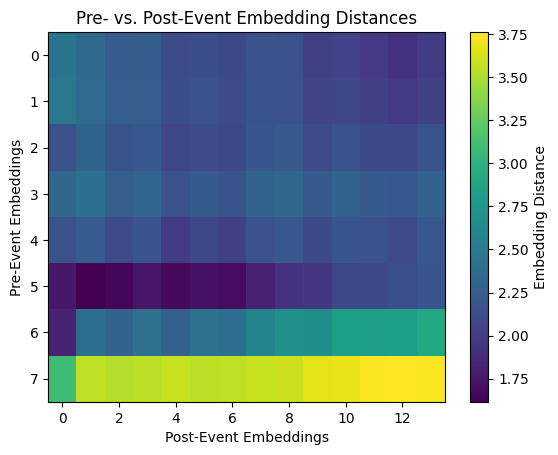

In [160]:
# Embeddings from pre- and post-flood
pre_event_embeddings = embeddings[:8]
post_event_embeddings = embeddings[8:]

# Calculate pairwise distances between pre- and post-event embeddings
# This computes a matrix of distances between every pre-event embedding and every post-event embedding.
distance_matrix = pairwise_distances(pre_event_embeddings, post_event_embeddings)
# We're quantifying how much the embedding space has changed, assuming that semantic changes (like flooding) shift embeddings.

# Get the average of the distance matrix
avg_distance = np.mean(distance_matrix)
print(f"Average embedding distance between pre- and post-event: {avg_distance:.4f}")
# One number representing how different the pre/post embeddings are overall.

# Visualize the differences
plt.imshow(distance_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Embedding Distance")
plt.title("Pre- vs. Post-Event Embedding Distances")
plt.xlabel("Post-Event Embeddings")
plt.ylabel("Pre-Event Embeddings")
plt.show()

It might be helpful to look once more at the images chronologically ordered after visualizing the graph above.

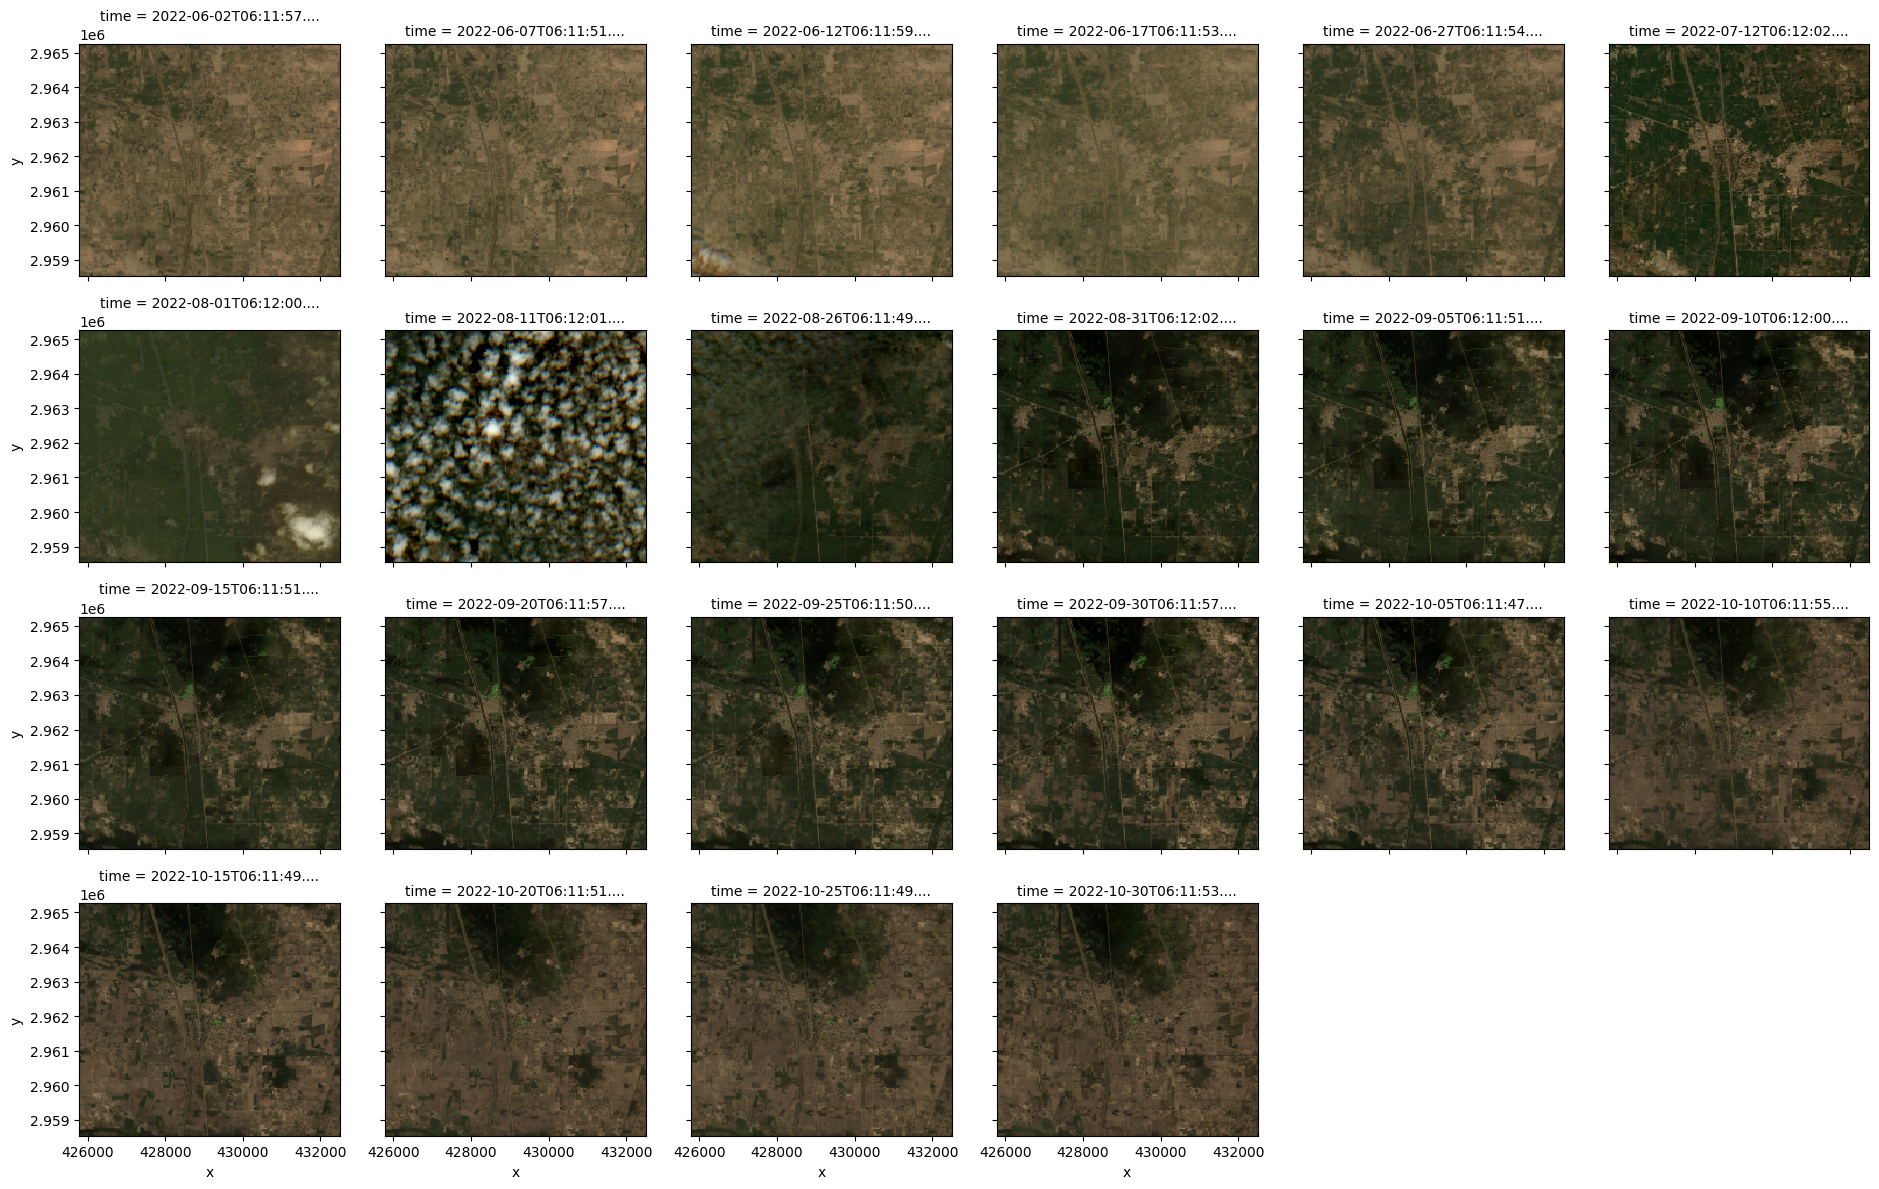

In [161]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=25000, col_wrap=6
)

### Discussion

---

#### How do I know when EOFMs are the right tool?

EOFMs are particularly suitable when:

* You have **limited labeled data**
* Your task requires **generalizable spatial or temporal reasoning**
* You want to **transfer models across regions or sensors**
* You seek to build **multi-task pipelines** (e.g., classification + segmentation + anomaly detection)

They are less appropriate when:

* You have abundant labels and simple classification tasks
* Computational cost is a constraint
* Model interpretability is the top priority

---

#### How does the use of EOFMs compare to the performance of other approaches?

##### Zero-shot

This means of use is addressed in the chapter. Zero-shot performance (without task-specific training) gives a baseline for how well the pretrained EOFM has generalized from pretraining to your task domain. This is a strength of Prithvi and CLAY in particular, as they can encode rich geospatial patterns directly from input data.

##### Fine-tuning

Fine-tuning should be benchmarked alongside zero-shot usage in practice when using a specialized dataset, or when training for downstream tasks. Fine-tuning can enable domain-specific adaptation and often improves accuracy, particularly in edge cases or for features not well represented in pretraining. This comes with increased computational cost and overfitting risk if data is limited.

##### Simpler methods

It's essential to benchmark EOFMs against simpler baselines like:

* Classical remote sensing indices + Random Forest
* SVM
* Spectral-only MLPs
* Convolutional Neural Networks

These comparisons help quantify whether the added complexity of a foundation model is justified for your task.

##### Other feature reduction techniques

Other unsupervised methods like pure PCA, autoencoders, or temporal summaries may be compared to EOFM embeddings when used as input to downstream classifiers. This allows us to understand whether EOFMs truly encode more discriminative or transferable features than conventional feature engineering pipelines.

---

#### How does the performance of different models compare relative to each approach’s resource consumption?

| Model Type              | Performance               | Compute Cost | Training Data Needed | Suitability                       |
| ----------------------- | ------------------------- | ------------ | -------------------- | --------------------------------- |
| EOFM (Prithvi/CLAY)     | High (esp. zero/few shot) | High         | Low–Moderate         | Complex, generalizable tasks      |
| Random Forest + Indices | Medium                    | Low          | Moderate             | Simple tasks                      |
| CNN from scratch        | Medium–High               | Medium–High  | High                 | Supervised tasks with many labels |
| PCA + SVM               | Low–Medium                | Very Low     | Moderate             | Baselines, small-scale tasks      |

---

#### What kinds of interpretability can be done?

* **Attention maps** (e.g., from ViT-based EOFMs like Prithvi and Clay)
* **Similarity search** using embedding distances (semantic matching)
* **Visualization of embedding spaces** (UMAP/t-SNE for EO tasks)

For Prithvi and CLAY, embedding-based analysis (e.g., clustering, retrieval, similarity) is particularly powerful, though attribution methods are still emerging.

---

#### How can I use the information above to ensure I choose the right method?

Choosing between methods depends on:

* **Label availability** (EOFMs are strong when labels are scarce)
* **Task complexity** (fine-grained or abstract tasks benefit more from EOFMs)
* **Computation available** (EOFMs are heavier; classical methods are leaner)
* **Performance delta** (if EOFMs outperform simple methods only marginally, simpler methods may be preferable)

---

#### How can we stratify train, test, and validation to ensure proper evaluation?

* **Spatial stratification**: sample by region or tile, carefully to avoid spatial leakage
* **Temporal stratification**: ensure held-out time stamps in test set
* **Environmental conditions**: vary climate, terrain, and seasonality
* **Stratified sampling**: ensure class balance in all sets (important for rare class detection)

Avoid random pixel-based splits—these can overestimate performance due to spatial autocorrelation.

---

#### How can we evaluate at both the tile and map level to ensure proper continuity and qualitative “reasonability” of the output?

* **Tile-level metrics**: per-tile accuracy, F1, confusion matrices
* **Map-level coherence**: visually inspect maps for spatial discontinuities, fragmentation, or unreasonable transitions
* **Temporal consistency**: ensure predictions are temporally smooth where expected (e.g., gradual seasonal change)

Use moving window accuracy checks and expert review of map artifacts. EOFMs can occasionally "hallucinate" features if the embedding has been poorly grounded.

---

#### What to do when one's label set is limited?

* **Use EOFM embeddings as features**: they encode high-level patterns without requiring supervised training
* **Leverage weak supervision**: use coarsely labeled data
* **Few-shot fine-tuning**: tune only the last layer with a handful of labels
* **Self-training or pseudo-labeling**: train on confident predictions
* **Domain adaptation**: try transferring from well-labeled regions to unlabeled ones.

### Conclusion

In this notebook, we have demonstrated how to evaluate two EOFMs on a real historical event. Through these examples, the goal was to illustrate how EOFMs can be used to generate embeddings from relevant satellite imagery, observe salient patterns within the data, and subsequently expedite classification of an event by way of fine-tuning. This has been a practical series of tasks one might use to evaluate the efficacy of an EOFM for their unique problem.